# 0. Import Libaries + Data

In [1]:
!pip install changepoynt

In [2]:
# import pandas as pd
# import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates

from datetime import datetime
import dateutil.parser
import copy

# from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
# from sklearn.metrics import classification_report,roc_auc_score, make_scorer
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import MinMaxScaler,StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# from sklearn.base import BaseEstimator, TransformerMixin


# import tensorflow as tf
# from tensorflow.keras import backend as K
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# from keras.regularizers import l1, l2
# from keras.optimizers import Adam

# from sklearn import tree
# from sklearn.base import BaseEstimator
# from sklearn.preprocessing import StandardScaler

# from hypopt import GridSearch
# import keras_tuner as kt

# from keras.models import Sequential
# from keras.layers import Dense, LSTM
# from keras.losses import BinaryCrossentropy

# from optuna import Trial, create_study, create_trial



import warnings
warnings.filterwarnings("ignore")

In [3]:
from model import *
from preprocess import *
from crawling import *

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [4]:
start_time = '2017-12-31'
# start_time = '2023-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_full = VN_Stock_fully_data(start_time, end_time)

In [5]:
# start_time = '2017-12-31'
# end_time = '2025-03-01'

# list_choice = 'VN30'

# hourly_test = VN_Stock_close_data(start_time, end_time, interval = '1H')
# hourly_test

In [6]:
start_time = '2017-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_test = VN_Stock_close_data(start_time, end_time)
daily_test

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,6.81,NaN,14.90,57.74,16.65,18.17,57.64,NaN,NaN,10.85,...,NaN,NaN,23.41,NaN,3.50,57.44,118.84,105.37,8.73,37.54
2018-01-03,6.79,NaN,14.79,56.73,16.55,18.17,58.91,NaN,NaN,10.82,...,NaN,NaN,23.37,NaN,3.50,59.13,119.49,106.57,8.74,37.58
2018-01-04,6.81,NaN,15.20,57.32,17.15,18.54,61.69,NaN,NaN,10.96,...,NaN,NaN,23.58,NaN,3.53,59.50,119.97,107.02,9.06,37.42
2018-01-05,6.81,NaN,15.12,56.05,16.75,18.23,60.72,NaN,9.78,10.91,...,NaN,NaN,22.98,NaN,3.66,58.77,119.97,106.37,8.96,37.26
2018-01-08,7.04,NaN,15.37,57.07,17.15,18.51,60.72,NaN,9.81,11.25,...,NaN,NaN,23.58,NaN,3.86,58.99,119.65,104.63,9.37,36.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,21.85,74.5,41.10,58.70,41.90,139.31,68.60,32.45,23.45,27.70,...,26.50,15.89,62.54,40.25,20.01,40.60,96.60,61.62,19.03,17.35
2025-02-25,21.72,76.6,41.25,57.20,41.85,137.82,68.70,32.10,23.20,27.50,...,26.40,15.80,61.94,40.75,19.96,40.70,96.10,60.75,18.84,17.25
2025-02-26,21.68,76.4,41.20,57.80,41.35,140.59,68.40,32.60,23.05,27.75,...,26.30,15.80,61.74,40.70,19.82,41.00,97.10,60.94,18.74,17.15


In [7]:
daily_test.to_csv('daily_test.csv')

In [8]:
# plt.plot(30 - daily_test.isna().sum(axis = 1))
# plt.title(f"Số lượng công ty trên {list_choice} có dữ liệu theo thời gian")
# plt.xlabel("Thời gian")
# plt.ylabel("Số lượng công ty")

# 1. Analysis

In [9]:
def describe_data_list(data):
  ''' Hàm mô tả dữ liệu
      INPUT: data_list(list): Một list bao gồm các dataframe
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: các thông tin chung và mô tả các biến số của tất cả dataframe có trong list
  '''
  print(data.name)
  print(data.info())
  print(data.describe())
  print("=========================================")

  return

In [10]:
# plt.figure(figsize = (24, 12))
# plt.tight_layout()
# plt.xticks([])
# plt.yticks([])
# sns.reset_orig()
# plt.suptitle("Khối lượng giao dịch của các công ty trong VN30")
# for x in range(1,31):
#   ax = plt.subplot(5,6, x)
#   ax.plot(daily_full[x-1].index,daily_full[x-1]['volume'])
#   plt.xticks([])
#   plt.title(daily_full[x-1].name)
#   # plt.savefig(daily_full[x].name)

# 2. Cleaning Data

In [11]:
daily_full[0]["Date"] = daily_full[0].index
daily_full[0].set_index("Date", inplace = True)
daily_full[0]

,open,high,low,close,volume
Date,,,,,
2018-01-02,6.49,6.83,6.46,6.81,3657426
2018-01-03,6.81,6.86,6.67,6.79,5056543
2018-01-04,6.79,6.83,6.74,6.81,6365641
2018-01-05,6.84,6.93,6.74,6.81,6453452
2018-01-08,6.81,7.04,6.81,7.04,3879771
...,...,...,...,...,...
2025-02-24,21.76,21.93,21.76,21.85,6403121
2025-02-25,21.85,21.93,21.72,21.72,6482543
2025-02-26,21.76,21.81,21.68,21.68,5061653


# 3. Feature Engineering

In [12]:
num_feature = feature_engineering(daily_full[0])[1] - 2
feature = pd.DataFrame(np.empty((0, num_feature + 2)))
for x in range(0,30):
  temp = feature_engineering(daily_full[x])[0]
  feature.columns = temp.columns
  feature = pd.concat([feature,temp], axis = 0)
  # print(feature.shape)
feature = feature.sort_index()


0.07502900000000001 13.2985 24.134319466811647
0.07502900000000001 13.2985 24.134319466811647
1.7736893750000013 52.48025 505.23647237849815
0.606037499999999 25.1935 55.3242178030916
1.9814507500000005 49.44199999999999 173.94597381122088
0.48401874999999994 24.51525 53.22973150982197
0.7378063750000003 52.327 1302.1097428082726
3.0733027500000003 68.733 97.57024001944319
0.5954447500000011 18.717499999999998 92.62495666297781
0.11708400000000012 11.7375 21.485847103578713
0.2823367499999998 19.674750000000003 71.18489470230442
0.07807599999999992 7.631750000000001 46.09608767355901
0.12237575000000012 12.99475 24.82328953837828
5.7391763749999996 73.1625 464.13620433038204
1.547399 41.52275 219.81844515394206
1.2912758750000006 43.411249999999995 55.33061591301677
2.962586875000005 76.32124999999999 288.6978516585448
0.05175275000000003 7.766 12.706850269928816
0.1769298749999999 21.262499999999996 6.696034828907852
0.3297797499999999 14.92175 69.24392031699601
0.45352275 21.56874999

In [13]:
feature['good_signal'].value_counts()

good_signal
0.0    32760
1.0    12100
Name: count, dtype: int64

In [14]:
# feature = pd.get_dummies(feature, columns=['Symbol'], drop_first = True)
# feature = feature.drop(['Symbol'],axis = 1)
feature

,Symbol,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,ROC15,MACD_1_5,MACD_5_20,MACD_20_60,VWAP,changepoint_bocd,signal_momentum,good_signal,Close
2019-01-04,ACB,0.261905,0.25,0.403909,0.333333,0.492348,0.456349,0.006410,-0.044140,-0.014129,-0.044140,-0.084548,-0.088069,-0.143337,-0.156807,7.463786,0.054031,-0.087209,0.0,6.28
2019-01-04,VJC,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,-0.116758,-2.454183,-5.481703,-6.273283,145.110446,0.108102,-0.124827,0.0,114.00
2019-01-04,VRE,0.225907,0.30,0.414148,0.433333,0.468317,0.432540,-0.007432,-0.014391,-0.058181,-0.115856,-0.161645,-0.672996,-1.584344,-0.887964,36.513193,0.126678,-0.165312,0.0,26.71
2019-01-04,BID,0.389565,0.30,0.454268,0.383333,0.510975,0.484127,-0.014156,-0.082719,-0.032240,-0.052259,-0.089435,-0.577409,-0.292983,0.155836,17.735836,0.069522,-0.067987,0.0,17.41
2019-01-04,SHB,0.229167,0.10,0.364055,0.216667,0.478261,0.365079,0.000000,-0.026119,-0.026119,-0.054348,-0.090592,-0.035637,-0.075726,-0.112358,3.978772,0.053033,-0.090592,0.0,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,BVH,0.688312,0.45,0.637387,0.466667,0.561680,0.440476,-0.020761,-0.010490,-0.024138,0.040441,0.086372,-0.643901,1.894701,3.271105,50.101616,0.000000,0.114173,0.0,56.60
2025-02-28,BID,0.595960,0.50,0.574335,0.516667,0.483083,0.428571,0.000000,-0.007273,0.001222,0.007380,0.011111,-0.046944,0.462302,0.735471,27.245200,0.000000,0.023750,0.0,40.95
2025-02-28,VPB,0.579592,0.50,0.516949,0.416667,0.512124,0.436508,0.000000,-0.002654,-0.007396,0.015676,0.018428,0.002604,0.194517,0.069097,17.136746,0.000000,0.021196,0.0,18.79
2025-02-28,VIB,0.523585,0.55,0.613520,0.516667,0.530721,0.396825,0.005035,0.000000,0.007064,0.014743,0.012170,0.067507,0.199288,0.553448,15.558699,0.000000,0.005035,0.0,19.96


In [15]:
# feature.to_csv("feature.csv")

In [16]:
# corr = feature.drop(columns = ['Symbol']).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [17]:
feature

,Symbol,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,ROC15,MACD_1_5,MACD_5_20,MACD_20_60,VWAP,changepoint_bocd,signal_momentum,good_signal,Close
2019-01-04,ACB,0.261905,0.25,0.403909,0.333333,0.492348,0.456349,0.006410,-0.044140,-0.014129,-0.044140,-0.084548,-0.088069,-0.143337,-0.156807,7.463786,0.054031,-0.087209,0.0,6.28
2019-01-04,VJC,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,-0.116758,-2.454183,-5.481703,-6.273283,145.110446,0.108102,-0.124827,0.0,114.00
2019-01-04,VRE,0.225907,0.30,0.414148,0.433333,0.468317,0.432540,-0.007432,-0.014391,-0.058181,-0.115856,-0.161645,-0.672996,-1.584344,-0.887964,36.513193,0.126678,-0.165312,0.0,26.71
2019-01-04,BID,0.389565,0.30,0.454268,0.383333,0.510975,0.484127,-0.014156,-0.082719,-0.032240,-0.052259,-0.089435,-0.577409,-0.292983,0.155836,17.735836,0.069522,-0.067987,0.0,17.41
2019-01-04,SHB,0.229167,0.10,0.364055,0.216667,0.478261,0.365079,0.000000,-0.026119,-0.026119,-0.054348,-0.090592,-0.035637,-0.075726,-0.112358,3.978772,0.053033,-0.090592,0.0,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,BVH,0.688312,0.45,0.637387,0.466667,0.561680,0.440476,-0.020761,-0.010490,-0.024138,0.040441,0.086372,-0.643901,1.894701,3.271105,50.101616,0.000000,0.114173,0.0,56.60
2025-02-28,BID,0.595960,0.50,0.574335,0.516667,0.483083,0.428571,0.000000,-0.007273,0.001222,0.007380,0.011111,-0.046944,0.462302,0.735471,27.245200,0.000000,0.023750,0.0,40.95
2025-02-28,VPB,0.579592,0.50,0.516949,0.416667,0.512124,0.436508,0.000000,-0.002654,-0.007396,0.015676,0.018428,0.002604,0.194517,0.069097,17.136746,0.000000,0.021196,0.0,18.79
2025-02-28,VIB,0.523585,0.55,0.613520,0.516667,0.530721,0.396825,0.005035,0.000000,0.007064,0.014743,0.012170,0.067507,0.199288,0.553448,15.558699,0.000000,0.005035,0.0,19.96


In [18]:
# def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

#     scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
#     scaled_data.drop(columns = ['Symbol'], inplace = True)

#     for company, group in train_data.groupby('Symbol'):  # Process each company separately
#       non_scaled_data = group[['signal_momentum',]]

#       # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
#       volume_data = group[['Volume']]

#       temp = group
#       temp.drop(columns = ['signal_momentum'], inplace = True)
#       # Tính daily volatility (vol)
#       temp = temp.ewm(ignore_na=ignore_na,
#                             adjust=adjust,
#                             com=com,
#                             min_periods=min_periods).std(bias = False)

#       temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

#       volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

#       temp = pd.concat([temp, non_scaled_data], axis=1)
#       temp = pd.concat([temp, volume_data], axis=1)

#       scaled_data = pd.concat([scaled_data,temp], axis = 0)

#     return scaled_data

# scaler = FunctionTransformer(Volatility_scale)

In [19]:
# def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

#     scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
#     scaled_data.drop(columns = ['Symbol'], inplace = True)

#     for company, group in train_data.groupby('Symbol'):  # Process each company separately
#     #   non_scaled_data = group[['signal_momentum','RSI20','RSI60','RSI252','PSY20','PSY60','PSY252']]

#     #   # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
#     #   volume_data = group[['Volume']]

#       temp = group
#       temp.drop(columns = ['Symbol'], inplace = True)
#     #   # Tính daily volatility (vol)
#     #   temp = temp.ewm(ignore_na=ignore_na,
#     #                         adjust=adjust,
#     #                         com=com,
#     #                         min_periods=min_periods).std(bias = False)

#     #   temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

#     #   volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

#     #   temp = pd.concat([temp, non_scaled_data], axis=1)
#     #   temp = pd.concat([temp, volume_data], axis=1)

#       scaled_data = pd.concat([scaled_data,temp], axis = 0)

#     return scaled_data

# scaler = FunctionTransformer(Volatility_scale)

In [20]:
# corr = Volatility_scale(feature).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [21]:
# class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.previous_max = {}  # Store max per column

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         transformed_df = pd.DataFrame(index=X.index, columns=X.columns)

#         for col in X.columns:
#             col_values = X[col].values.astype(float)
#             running_max = self.previous_max.get(col, col_values[0])  # Keep previous max

#             transformed_col = np.zeros_like(col_values)
#             for i in range(len(col_values)):
#                 if i == 0 and col not in self.previous_max:
#                     transformed_col[i] = col_values[i]  # Keep first value
#                 else:
#                     running_max = max(running_max, col_values[i - 1])
#                     transformed_col[i] = (col_values[i] - running_max) / running_max if running_max != 0 else 0

#             transformed_df[col] = transformed_col
#             self.previous_max[col] = running_max  # Save max for next batch

#         return transformed_df


In [22]:
# for x ,y in trainX.groupby('Symbol'):
#     print(f"Processing {x}")
#     print(y)

In [23]:
class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
    def __init__(self, list_choice):
        stock = Vnstock().stock(symbol='ACB', source='VCI')
        self.company_column = stock.listing.symbols_by_group(list_choice) # Column name identifying companies
        self.previous_min = {}  # Store cumulative min per (company, column)
        self.previous_max = {}  # Store cumulative max per (company, column)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        transformed_df = pd.DataFrame(columns=X.columns, dtype=float)
        transformed_df.drop(columns = ['Symbol'], inplace = True)
        print(X.groupby(self.company_column))
        for company, group in X.groupby('Symbol'):  # Process each company separately
            temp = pd.DataFrame(index= group.index, columns=X.columns, dtype=float)
            temp.drop(columns = ['Symbol'], inplace = True)
            # print(f"Processing {company}")
            # print(group)
            for col in group.columns:
                if col == 'Symbol':
                    continue  # Skip the company column

                col_values = group[col].astype(float)
                # print(col_values)

                # Retrieve previous min/max for this (company, column) pair
                key = (company, col)
                running_min = self.previous_min.get(key, col_values.iloc[0])
                running_max = self.previous_max.get(key, col_values.iloc[0])

                # Compute cumulative min and max
                cumin_t = np.minimum.accumulate(np.insert(col_values.values, 0, running_min))[1:]
                cumax_t = np.maximum.accumulate(np.insert(col_values.values, 0, running_max))[1:]

                # print([cumin_t,cumax_t])

                # Apply scaling formula
                transformed_col = (col_values - cumin_t) / (cumax_t - cumin_t)
                transformed_col = np.nan_to_num(transformed_col, nan=0.0)  # Handle division by zero

                temp[col] = transformed_col

                # Store the last min and max for future use
                self.previous_min[key] = cumin_t[-1]
                self.previous_max[key] = cumax_t[-1]

            transformed_df = pd.concat([transformed_df,temp], axis = 0)
            transformed_df = transformed_df.sort_index()

        return transformed_df


In [24]:
def prepare_X_y(df):
    ''' Hàm chia X,y từ dữ liệu
          INPUT: df(dataframe): dữ liệu đã được tạo feature
          OUTPUT: X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
    '''
    columns = df.columns.tolist()
    remove_list = ['Symbol', 'Close', 'good_signal']
    columns = list(set(columns) - set(remove_list))
    X = df[columns]
    info = df[['Symbol', 'Close']]
    y = df['good_signal']

    return X, y , info

def split_train_test(X, y, info, train_size=0.8):
    ''' Hàm chia tập train, test cho dữ liệu:
          INPUT:
            X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
            train_size: tỉ lệ chia train/test; mặc định là 0.8
          OUTPUT: trainX, testX ,trainY, testY(dataframe): các tập train/test đã được chia ra
    '''
    # Chia tập train/test
    # trainX, testX ,trainY, testY = train_test_split(X, y, train_size=train_size, shuffle=False)

    split_idx = int(len(X) * train_size)  # Compute the split index

    trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
    trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]
    infoX, infoY = info.loc[info.index <= dateutil.parser.parse(str(info.iloc[[split_idx]].index[0]))], info.loc[info.index > dateutil.parser.parse(str(info.iloc[[split_idx]].index[0]))]

    # In ra những thông tin chi tiết về kích cỡ tập train/test; và khoảng thời gian xử lí
    print('TrainX:' + str(trainX.shape) + f". Dữ liệu từ ngày {trainX.index.min().date()} đến {trainX.index.max().date()}")
    print('TrainY:' + str(trainY.shape) + f". Dữ liệu từ ngày {trainY.index.min().date()} đến {trainY.index.max().date()}")
    print('TestX:' + str(testX.shape) + f". Dữ liệu từ ngày {testX.index.min().date()} đến {testX.index.max().date()}")
    print('TestY:' + str(testY.shape) + f". Dữ liệu từ ngày {testY.index.min().date()} đến {testY.index.max().date()}")

    return trainX, testX ,trainY, testY , infoX, infoY

In [25]:
# def manual_time_series_split(data, n_splits = 5):
#     """Manually splits time series data into train-test sets."""
#     n_samples = len(data)
#     split_size = (n_samples - n_splits) // (n_splits + 1)  # Size of each test set

#     splits = []
#     for i in range(n_splits):
#         train_end = split_size * (i + 1) + i  # Expanding train set
#         test_start = train_end
#         test_end = test_start + split_size

#         train_indices = np.argwhere(data.index <= dateutil.parser.parse(str(data.iloc[[train_end]].index[0]))).flatten().tolist()
#         test_indices = np.argwhere((data.index <= dateutil.parser.parse(str(data.iloc[[test_end]].index[0]))) & (data.index > dateutil.parser.parse(str(data.iloc[[test_start]].index[0])))).flatten().tolist()

#         splits.append((train_indices, test_indices))

#     return splits

In [26]:
# # Scale data before applying PCA
# # Scaled_data = Volatility_scale(trainX)[1:]
# Scaled_data = Volatility_scale(trainX)

# # Use fit and transform method

# # Set the n_components=3
# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# # Check the dimensions of data after PCA
# print(x.shape)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()



In [27]:
X, y,info = prepare_X_y(feature)

trainX, testX ,trainY, testY, infoX,infoY = split_train_test(X, y,info)
print(trainX)
print(trainY)

TrainX:(35890, 17). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TrainY:(35890,). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TestX:(8970, 17). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
TestY:(8970,). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
               ROC10      ROC3  PSY20    PSY252     ROC15  signal_momentum  \
2019-01-04 -0.044140 -0.044140   0.25  0.456349 -0.084548        -0.087209   
2019-01-04 -0.079977 -0.041695   0.30  0.456349 -0.116758        -0.124827   
2019-01-04 -0.115856 -0.014391   0.30  0.432540 -0.161645        -0.165312   
2019-01-04 -0.052259 -0.082719   0.30  0.484127 -0.089435        -0.067987   
2019-01-04 -0.054348 -0.026119   0.10  0.365079 -0.090592        -0.090592   
...              ...       ...    ...       ...       ...              ...   
2023-12-13  0.016724 -0.005576   0.40  0.492063  0.009815        -0.010359   
2023-12-13  0.010982 -0.004453   0.45  0.440476 -0.017577        -0.041054   
2023-12-13 -0.008621 -0.014989   0.45  0.444444  0.008772   

In [28]:
# # Scale data before applying PCA
# Scaled_data = TimeSeriesScalerDF().transform(trainX)
# # Scaled_data = trainX

# # Use fit and transform method

# # Set the n_components=2

# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()


In [29]:
# trainX = pd.DataFrame(np.empty((0,36)))
# testX = pd.DataFrame(np.empty((0,36)))
# trainY = pd.Series()
# testY = pd.Series()
# for x in range(0,30):
#   temp = feature_engineering(daily_full[x])

#   X, y = prepare_X_y(temp)

#   trainX_temp, testX_temp ,trainY_temp, testY_temp = split_train_test(X, y)
#   trainX.columns = trainX_temp.columns
#   trainX = pd.concat([trainX,trainX_temp], axis = 0)
#   testX.columns = testX_temp.columns
#   testX = pd.concat([testX,testX_temp], axis = 0)
#   trainY = pd.concat([trainY,trainY_temp], axis = 0)
#   testY = pd.concat([testY,testY_temp], axis = 0)

#   print([trainX.shape,trainY.shape,testX.shape, testY.shape])

# 4. Model

## Random forest

In [30]:
# # Generate a sample time series dataset
# X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

# # Manually define test fold indices for a time series split (5 folds)
# n_samples = len(y)
# n_splits = 5
# test_size = n_samples // (n_splits + 1)  # Ensure growing training set
# test_fold = np.full(n_samples, -1)  # Initialize all as training (-1)

# for i in range(n_splits):
#     start_test = (i + 1) * test_size
#     end_test = start_test + test_size
#     test_fold[start_test:end_test] = i  # Assign fold number

# # Create PredefinedSplit
# ps = PredefinedSplit(test_fold)


# split_idx = int(len(X) * train_size)  # Compute the split index

# trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
# trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]


In [31]:
test_model = train_random_forest(trainX,trainY)

# test_model = train_random_forest_optuna(trainX,trainY)

In [32]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26258
         1.0       1.00      1.00      1.00      9632

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [33]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      6502
         1.0       0.52      0.48      0.50      2468

    accuracy                           0.74      8970
   macro avg       0.67      0.66      0.66      8970
weighted avg       0.73      0.74      0.73      8970



In [34]:
# prediction = test_model.predict(trainX)
# prediction *= np.sign(trainX["signal_momentum"])
# print(classification_report(np.sign(trainX["signal_momentum"]) * trainY, prediction))

In [35]:
# prediction = test_model.predict(testX)
# prediction *= np.sign(testX["signal_momentum"])
# print(classification_report(np.sign(testX["signal_momentum"]) * testY, prediction))

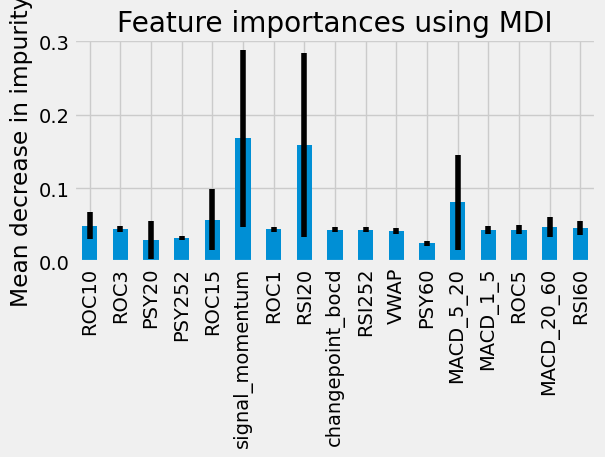

In [36]:
importances = test_model['classifier'].feature_importances_

# feature_names = trainX.drop(columns = ['Symbol']).columns

feature_names = trainX.columns


forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in test_model['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [37]:
# import pickle

# # save the iris classification model as a pickle file
#   model_pkl_file = "random_forest_model_0.5892.pkl"

# with open(model_pkl_file, 'wb') as file:
#     pickle.dump(test_model, file)

# Sharpe Loss

In [38]:
model, history = train_Lasso_supervised(trainX, trainY,1,1, num_feature= num_feature - 1,binary = True)
# model, history = train_LSTM_supervised(trainX, trainY,1,binary = True)  

Trial 100 Complete [00h 00m 49s]
loss: 0.45570236444473267

Best loss So Far: 0.4550081491470337
Total elapsed time: 00h 35m 28s
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5462
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5111
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4962
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4894
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4823
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4836
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4792
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4691
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4776
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4756
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4749
Epoch 12/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4717
Epoch 13/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (156.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26 (108.00 B)

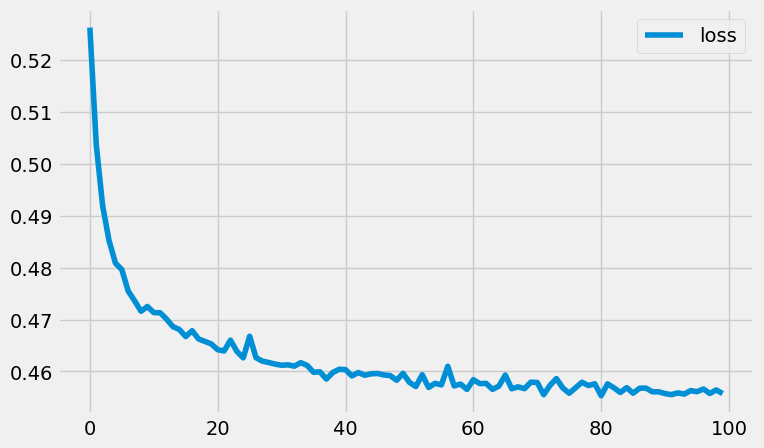

In [40]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [41]:
prediction = test_model.predict(trainX)
print(classification_report( trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     26763
         1.0       1.00      1.00      1.00      9127

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [42]:
prediction = test_model.predict(testX)
print(classification_report( testY, prediction))

              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      6525
         1.0       0.49      0.39      0.43      2445

    accuracy                           0.72      8970
   macro avg       0.64      0.62      0.63      8970
weighted avg       0.71      0.72      0.71      8970



In [43]:
np.unique(prediction, return_counts= True)

(array([0., 1.]), array([7054, 1916], dtype=int64))

In [ ]:
model, history = train_MLP_supervised(trainX, trainY,1,1,  num_feature= num_feature,binary = True)

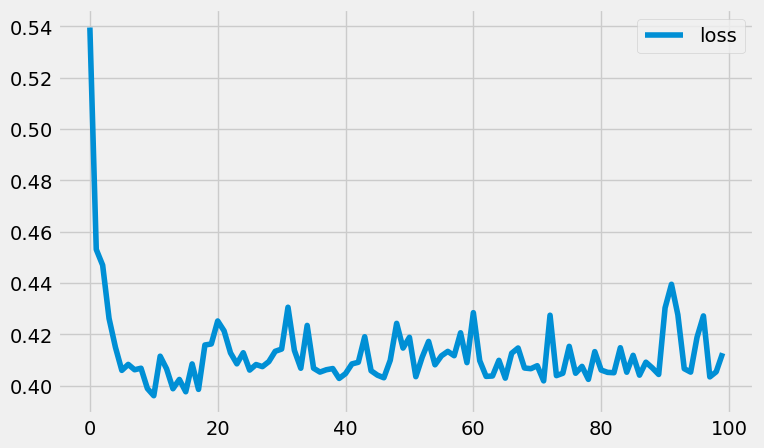

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_2 (Dropout)             │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380 (1.49 KB)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254 (1020.00 B)

In [ ]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29458
         1.0       1.00      1.00      1.00      6432

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [ ]:
prediction = test_model.predict(testX)
print(classification_report(testY, prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      8121
         1.0       0.66      0.47      0.55       849

    accuracy                           0.93      8970
   macro avg       0.80      0.72      0.75      8970
weighted avg       0.92      0.93      0.92      8970



In [ ]:
np.unique(prediction, return_counts= True)

(array([0., 1.]), array([8361,  609], dtype=int64))

In [ ]:
model, history = train_LSTM_supervised(trainX, trainY,1, num_feature= num_feature,binary = True)  

Trial 100 Complete [00h 04m 16s]
loss: 0.306769996881485

Best loss So Far: 0.2743125557899475
Total elapsed time: 05h 52m 05s
Epoch 1/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6251
Epoch 2/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4238
Epoch 3/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.3917
Epoch 4/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3715
Epoch 5/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3583
Epoch 6/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3493
Epoch 7/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3464
Epoch 8/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3334
Epoch 9/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3409
Epoch 10/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3328
Epoch 11/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3297
Epoch 12/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3341
Epoch 13/100
561/561 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step 

In [ ]:
model.get_config()

{'name': 'sequential_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 11, 1),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_layer_1'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'return_sequences': False,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'zero_output_for_mask': False,
    'units': 16,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'Glor

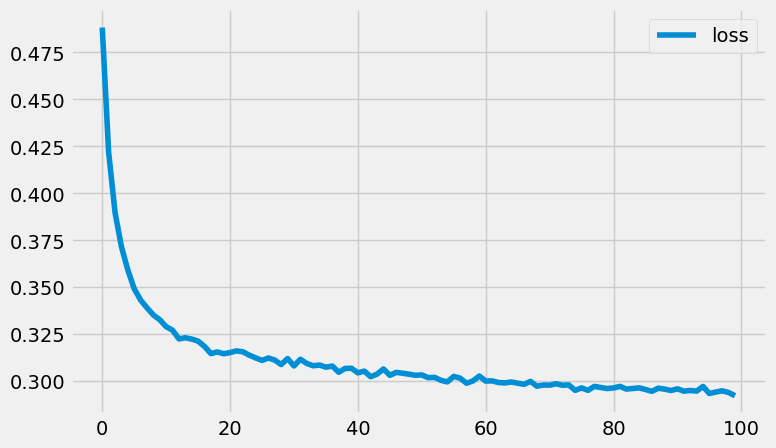

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           187 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,019 (15.70 KB)

 Trainable params: 1,339 (5.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,680 (10.47 KB)

In [ ]:
prediction = test_model.predict(trainX)
print(classification_report(trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29458
         1.0       1.00      1.00      1.00      6432

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [ ]:
prediction = test_model.predict(testX)
print(classification_report( testY, prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96      8121
         1.0       0.66      0.47      0.55       849

    accuracy                           0.93      8970
   macro avg       0.80      0.72      0.75      8970
weighted avg       0.92      0.93      0.92      8970

